In [ ]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import random
from absl import logging
logging.set_verbosity(logging.ERROR)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Concatenate
from tensorflow.keras.optimizers import Adam
from collections import deque
import random
import gym
from gym import spaces
import datetime
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import yfinance as yf
from sklearn.preprocessing import RobustScaler
import os

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-07-12 05:12:53.423520: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752297173.785322      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752297173.893345      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
os.chdir("..")
df=pd.read_csv("bitcoin_2020_2025.csv")

In [ ]:
def preprocess_data_mark2(df):
    """
    Args:
        df: DataFrame with OHLCV data

    Returns:
        DataFrame with preprocessed data including technical indicators
        normalizing everything last
    """
    # Handle missing values
    if df.isnull().sum().sum() > 0:
        print(f"Warning: Initial missing values found: {df.isnull().sum().sum()}")
        df = df.ffill()  # Forward fill
        df = df.bfill()  # Backward fill for any remaining NAs
    else:
        print("No missing values found, skipping fill operations.")
    df = df.drop(columns = ['Date'])
    # Simple Moving Averages
    df['SMA7'] = df['Close'].rolling(window=7).mean()  # 7-day SMA
    df['SMA25'] = df['Close'].rolling(window=25).mean() # 25-day SMA

    # MACD
    df['EMA12'] = df['Close'].ewm(span=12).mean() # 12-day EMA
    df['EMA26'] = df['Close'].ewm(span=26).mean() # 26-day EMA
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal'] = df['MACD'].ewm(span=9).mean()   # 9-day EMA of MACD
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean() # 14-day gain
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean() # 14-day loss
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    df['Daily_Return'] = df['Close'].pct_change()

    df['Norm_Close'] = df['Close'] / df['Close'].iloc[0]


    df.dropna(inplace=True)

    non_scaled_df = df.copy()



    scaler_price = RobustScaler()
    scaler_indicators = RobustScaler()

    price_cols = ['Open','High','Low','Close']
    all_prices = df[price_cols].values.reshape(-1, 1)
    scaler_price.fit(all_prices)
    for col in price_cols:
        df[col] = scaler_price.transform(df[[col]])


    non_price_columns = list(df.drop(columns=price_cols).columns)
    scaler_indicators.fit(df.drop(columns=price_cols))
    df[non_price_columns] = scaler_indicators.transform(df.drop(columns=price_cols))
    # print(array[:5])


    print(scaler_price.center_, scaler_price.scale_)
    # print(scaler_indicators.center_, scaler_indicators.scale_)

    return df, non_scaled_df


In [ ]:

# Preprocess the data
df_processed, non_scaled_processed_df = preprocess_data_mark2(df.copy())


No missing values found, skipping fill operations.
[32942.09765625] [31091.15673828]


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pandas/core/algorithms.py:1743: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.11/dist-pac

In [ ]:
import matplotlib.pyplot as plt

def visualize_data(df):
    """
    Visualize the cryptocurrency data with indicators, one graph at a time
    
    Args:
        df: DataFrame with preprocessed data
    """
    # Use the entire data
    plot_df = df
    
    # 1. Plot Price vs. Time (Close Price over Time)
    plt.figure(figsize=(15, 8))  # Adjust size for clarity
    plt.plot(plot_df.index, plot_df['Close'], label='Close Price', color='blue')
    plt.title('Price vs Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()  # Display the plot
    
    # 2. Price and Moving Averages
    plt.figure(figsize=(15, 8))  # Adjust size for clarity
    plt.plot(plot_df.index, plot_df['Close'], label='Close Price', color='blue')
    plt.plot(plot_df.index, plot_df['SMA7'], label='SMA 7', color='orange')
    plt.plot(plot_df.index, plot_df['SMA25'], label='SMA 25', color='green')
    plt.title('Price and Moving Averages')
    plt.ylabel('Price')
    plt.legend()
    plt.show()  # Display the plot
    
    # 3. MACD
    plt.figure(figsize=(15, 8))  # Adjust size for clarity
    plt.plot(plot_df.index, plot_df['MACD'], label='MACD', color='purple')
    plt.plot(plot_df.index, plot_df['Signal'], label='Signal', color='red')
    plt.bar(plot_df.index, plot_df['MACD'] - plot_df['Signal'], alpha=0.3, label='Histogram', color='gray')
    plt.title('MACD')
    plt.legend()
    plt.show()  # Display the plot
    
    # 4. RSI
    plt.figure(figsize=(15, 8))  # Adjust size for clarity
    plt.plot(plot_df.index, plot_df['RSI'], label='RSI', color='magenta')
    plt.axhline(y=70, color='r', linestyle='--', alpha=0.5)
    plt.axhline(y=30, color='g', linestyle='--', alpha=0.5)
    plt.title('RSI')
    plt.ylim(0, 100)
    plt.legend()
    plt.show()  # Display the plot
    
    # 5. Daily Returns
    plt.figure(figsize=(15, 8))  # Adjust size for clarity
    plt.plot(plot_df.index, plot_df['Daily_Return'], label='Daily Return', color='cyan')
    plt.title('Daily Returns')
    plt.ylabel('Daily Return')
    plt.legend()
    plt.show()  # Display the plot

# visualize_data(df_processed)


In [8]:

class DayTradingEnv:
    """
    A day trading environment which takes into account past history_length time steps into consideration

    The environment takes 2 pandas DataFrame, one with normalized price columns, other without normalization (to compute profit)
    with at least the following columns:
      - 'open': Opening prices
      - 'close': Closing prices
      - Any number of additional indicator columns

    Observations are the past history_length days of data for all features.

    Can be output in 2 ways:
      - '1D': a vector containing data from all days concatenated end to end
      - '2D': a matrix where one dimension is for the number of days, while the other is for features per day


    Actions:
      0 - Buy at opening price, sell at closing price
      1 - Sell at opening price, buy at closing price

    Reward:
      +1 for profitable trade, -1 for unprofitable trade or break-even

    Tracks:
      - total_profit: cumulative sum of profits
      - confusion_matrix: 2x2 matrix for actions taken vs optimal actions
    """
    def __init__(self, df: pd.DataFrame, non_normal_df: pd.DataFrame, history_length: int = 90, observation_dim='1D'): 
        # observation dim should be 2D while using the BiLSTM trainer
        
        
        self.raw_df = df.reset_index(drop=True)
        self.history_length = history_length
        self.n_steps = len(self.raw_df)
        self.obs_dim = observation_dim

        
        self.non_normal = non_normal_df
        df = self.raw_df.copy()

        self.data = df
        self.feature_cols = df.columns.tolist()

        # Spaces
        self.action_space = 2
        self.observation_space = (history_length, len(self.feature_cols))

        # Trackers
        self.total_profit = 0.0
        self.invested_amount = 0.0
        self.steps = 0
        self.confusion_matrix = np.zeros((2, 2), dtype=int)

        # Internal state
        self.current_step = None

    def reset(self):
        """
        Reset the environment state and trackers.
        Starts at the earliest valid index (history_length).
        """
        self.current_step = self.history_length
        self.total_profit = 0.0
        self.invested_ammount = 0.0
        self.confusion_matrix = np.zeros((2, 2), dtype=int)
        return self._get_observation()

    def step(self, action: int):
        """
        Run one timestep of the environment's dynamics.
        Returns: observation, reward, done, info
        """
        assert action in [0, 1], "Invalid Action"
        self.steps += 1
        # Today's prices
        today = self.data.iloc[self.current_step]
        open_price, close_price = today['Open'], today['Close']

        true_data = self.non_normal.iloc[self.current_step]
        tr_open_price, tr_close_price = true_data['Open'], true_data['Close']

        

        # Profit calculation
        profit_normal = (close_price - open_price)/open_price if action == 0 else (open_price - close_price)/close_price
        reward = +1 if profit_normal > 0 else -1

        true_profit = (tr_close_price - tr_open_price) if action == 0 else (tr_open_price - tr_close_price)
        invested = tr_open_price if action == 0 else tr_close_price
        
        # Update trackers
        self.total_profit += true_profit
        self.invested_amount += invested
        row = 0 if profit_normal > 0 else 1
        col = action
        self.confusion_matrix[row, col] += 1

        # Advance
        self.current_step += 1
        done = self.current_step >= self.n_steps

        if not done:
            obs = self._get_observation()
        else:
            self.current_step -= 1
            obs = np.zeros_like(self._get_observation())
            self.current_step += 1
        info = {
            'open': open_price,
            'close': close_price,
            'profit': profit_normal,
            'total_profit': self.total_profit,
            'confusion_matrix': self.confusion_matrix.copy()
        }

        return obs, reward, done, info
    


    def _get_observation(self):
        """
        Get the past history_length days of data as the observation.
        """
        start = self.current_step - self.history_length
        end = self.current_step
        obs_df = self.data.iloc[start:end]

        assert self.obs_dim in ['1D', '2D'], "Invalid dim shape"
        
        # ===================
        if self.obs_dim == '1D':
            out = obs_df.values.astype(np.float32).flatten()
        elif self.obs_dim == '2D':
            out = obs_df.values.astype(np.float32)
        # ===================

        
        
        return out

    def render_confusion_matrix(self):
        """
        Returns the confusion matrix in a pandas DataFrame for readability:
             action=0  action=1
        pos         x11       x12
        neg         x21       x22
        """

        
        # self.confusion_matrix = self.confusion_matrix/self.steps * 100 # If percentages needed
        
        print( pd.DataFrame(
            self.confusion_matrix,
            index=['profit>=0', 'profit<0'],
            columns=['action=0_buy', 'action=1_sell']
        ))


In [ ]:
       
class DDDQNTrainer_PrioritizedReplay_BiLSTM:
    '''
    Note this traininer can currently only interface with the Day trading env

    Please instantiate the Day trading env with observation_dim argument as '2D' for this network
    '''
    


    class DuelingBiLSTM(nn.Module):
        def __init__(
            self,
            single_day_dim: int,
            look_back_window: int,
            action_space_dim: int,
            rnn_hidden_space: tuple,
            fc_hidden_space: tuple
        ):
            super().__init__()
            
            # Build stacked bidirectional LSTMs
            self.rnns = nn.ModuleList()
            input_dim = single_day_dim
            for hidden_dim in rnn_hidden_space:
                self.rnns.append(
                    nn.LSTM(
                        input_size=input_dim,
                        hidden_size=hidden_dim,
                        num_layers=1,
                        bidirectional=True,
                        batch_first=True
                    )
                    
                )
                # after averaging forward/backward, next input_dim is hidden_dim
                input_dim = hidden_dim
            
            # Final encoded dimension (after averaging)
            self.encoded_dim = rnn_hidden_space[-1]

            # Build fully connected stack
            self.mlp = self.build_mlp(self.encoded_dim, fc_hidden_space)
            last_fc_dim = fc_hidden_space[-1] if fc_hidden_space else self.encoded_dim

            # Dueling heads
            self.value_head = nn.Linear(last_fc_dim, 1)
            self.advantage_head = nn.Linear(last_fc_dim, action_space_dim)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            """
            x: tensor of shape (batch, look_back_window, single_day_dim)
            returns: tensor of shape (batch, action_space_dim) -- Q-values
            """
            out = x
            # Pass through stacked bi-LSTMs with averaging of forward/back outputs
            for rnn in self.rnns:
                rnn_out, _ = rnn(out)
                # rnn_out shape: (batch, seq_len, 2*hidden_dim)
                h = rnn_out.size(2) // 2
                # average forward and backward features
                out = (rnn_out[:, :, :h] + rnn_out[:, :, h:]) / 2
            # out shape: (batch, seq_len, encoded_dim)

            # take last time step
            last_output = out[:, -1, :]  # (batch, encoded_dim)

            # Pass through FC layers
            features = self.mlp(last_output)

            # Compute value and advantage
            value = self.value_head(features)            # (batch, 1)
            advantage = self.advantage_head(features)    # (batch, action_space_dim)

            # Normalize advantage
            advantage_mean = advantage.mean(dim=1, keepdim=True)
            advantage_normalized = advantage - advantage_mean

            # Combine value and normalized advantage
            q_vals = value + advantage_normalized       # (batch, action_space_dim)
            return q_vals
            
        def build_mlp(self, input_dim, hidden_dims, activation=nn.ReLU):
            layers = []
            last_dim = input_dim
            for h in hidden_dims:
                layers.append(nn.Linear(last_dim, h))
                layers.append(activation())
                last_dim = h
            return nn.Sequential(*layers)
        
    class PrioritizedReplayBuffer:
        def __init__(self, max_len, min_len, offset= 0.1):
            self.max_len = max_len
            self.min_len = min_len
            self.offset = offset

            self.buffer = deque(maxlen=max_len)
            self.priorities = deque(maxlen=max_len)

        def is_min_len_reached(self):
            return len(self.buffer) >= self.min_len

        def add(self, transition):
            if self.priorities:
                max_prio = max(self.priorities)
            else:
                max_prio = self.offset
            self.buffer.append(transition)
            self.priorities.append(max_prio)

        def update_priorities(self, indices, errors):
            for idx, err in zip(indices, errors):
                prio = abs(err) + self.offset
                # Ensure idx in range
                if 0 <= idx < len(self.priorities):
                    self.priorities[idx] = prio

        def probabilities(self, priority_scale):
            prios = np.array(self.priorities, dtype=np.float64)
            scaled = prios ** priority_scale
            total = scaled.sum()
            if total == 0:
                # avoid division by zero
                return np.ones_like(scaled) / len(scaled)
            return scaled / total

        def importance_weights(self, priority_scale, importance_weight_scaling, indices=None):
            probs = self.probabilities(priority_scale)
            N = len(probs)
            if indices is None:
                idxs = np.arange(N)
            else:
                idxs = np.array(indices, dtype=int)
            weights = (1.0 / (N * probs[idxs])) ** importance_weight_scaling

            max_w = weights.max() if len(weights) > 0 else 1.0
            return weights / max_w

        def sample(self, batch_size, priority_scale, importance_weight_scaling):
            if not self.is_min_len_reached():
                raise ValueError(f"Not enough samples to sample: {len(self.buffer)}/{self.min_len}")

            probs = self.probabilities(priority_scale)
            N = len(probs)
            indices = np.random.choice(N, size=batch_size, replace=False, p=probs)
            transitions = [self.buffer[idx] for idx in indices]
            is_weights = self.importance_weights(priority_scale, importance_weight_scaling, indices)
            return transitions, indices.tolist(), is_weights

    def __init__(self, env, 
                 rnn_hidden_size=128, fcc_hidden_state=128,
                 gamma=0.97,
                 mem_min_len = 400, mem_max_len = 1_000,
                 batch_size=64, train_freq=10, train_times = 5, update_q_freq=20,
                 epsilon_start=1.0, epsilon_min=0.1,
                 epsilon_decay=0.95, start_reduce_epsilon=5,
                 epoch_num=60):
        self.env = env
        self.rnn_hidden_size = rnn_hidden_size
        self.fcc_hidden_size = fcc_hidden_state
        self.gamma = gamma
        self.batch_size = batch_size
        self.train_freq = train_freq
        self.train_times = train_times
        self.update_q_freq = update_q_freq
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.start_reduce_epsilon = start_reduce_epsilon
        self.epoch_num = epoch_num
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        sample_obs = self.env.reset()
        self.input_dim = sample_obs.shape # obs is (num_of_days, single_day_features)
        self.action_dim = self.env.action_space
        
        self.Q = self.DuelingBiLSTM(single_day_dim= self.input_dim[1], 
                                    look_back_window= self.input_dim[0], 
                                    action_space_dim= self.action_dim, 
                                    rnn_hidden_space= (self.rnn_hidden_size,), 
                                    fc_hidden_space= (self.fcc_hidden_size,)).to(self.device)
        self.Q_target = copy.deepcopy(self.Q).to(self.device)
        self.optimizer = optim.Adam(self.Q.parameters())
        

        
        self.memory = self.PrioritizedReplayBuffer(mem_max_len, mem_min_len)
        self.total_step = 0

        self.total_rewards = []
        self.total_losses = []
        self.total_profits = []

    def train(self):
        step_max = len(self.env.data) - 1
        start_time = time.time()

        for epoch in range(self.epoch_num):
            obs = self.env.reset()
            total_reward = 0
            total_loss = 0
            done = False
            step = 0


            while not done and step < step_max:
                # select action
                if np.random.rand() < self.epsilon:
                    action = np.random.randint(self.action_dim)
                else:
                    state_tensor = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
                    with torch.no_grad():
                        q_out = self.Q(state_tensor)
                    action = q_out.argmax(dim=1).item()

                # step environment; unpack info if provided
                step_result = self.env.step(action)
                if len(step_result) == 4:
                    next_obs, reward, done, info = step_result
                else:
                    next_obs, reward, done = step_result
                    info = {}

                # store in memory
                self.memory.add((obs, action, reward, next_obs, done))
        
                
                if self.memory.is_min_len_reached() and self.total_step % self.train_freq == 0:
                    for i in range(self.train_times):
                        transition, indices, is_weights = self.memory.sample(self.batch_size, 0.7, 1-self.epsilon)
                        
                        bs, ba, br, bnext, bd = zip(*transition)
                        
                        # print(bs)
                        bs = torch.tensor(bs, dtype=torch.float32, device=self.device)
                        
        
                        
                        ba = torch.tensor(ba, dtype=torch.long, device=self.device)
                        br = torch.tensor(br, dtype=torch.float32, device=self.device)
                        bnext = np.array(bnext)
                        bnext = torch.tensor(bnext, dtype=torch.float32, device=self.device)
                        bd = torch.tensor(bd, dtype=torch.float32, device=self.device)
                        is_weights = torch.tensor(is_weights, dtype=torch.float32, device=self.device)
                        

                        q_values = self.Q(bs)
                        
                        q_val = q_values.gather(1, ba.unsqueeze(1)).squeeze(1)
        
                        # Double DQN target
                        with torch.no_grad():
                            next_q = self.Q(bnext)
                            next_actions = next_q.argmax(dim=1, keepdim=True)
                            q_target_next = self.Q_target(bnext)
                            q_target_val = q_target_next.gather(1, next_actions).squeeze(1)
                            target = br + self.gamma * q_target_val * (1 - bd)
        
                        errors = (target - q_val).detach().cpu().numpy()
                        
                        loss = ((target-q_val) ** 2) * is_weights
                        loss = loss.mean()
                        self.optimizer.zero_grad()
                        loss.backward()
                        self.optimizer.step()
                        total_loss += loss.item()

                        
                        self.memory.update_priorities(indices, errors)
        
                        # Debuggin to check if reward is not normalized somehow
                        # if abs(reward) > 10:
                        #     print(f"env_step: {getattr(self.env, 'current_step', 0)}  reward: {reward}    loss: {loss.item()}")

                # update target network
                if self.total_step % self.update_q_freq == 0:
                    self.Q_target.load_state_dict(self.Q.state_dict())

                # epsilon decay
                if self.total_step > self.start_reduce_epsilon:
                    self.epsilon = max(self.epsilon_min, self.epsilon - self.epsilon_decay)
                
                obs = next_obs
                total_reward += reward
                step += 1
                self.total_step += 1

            # end of episode logging
            self.total_rewards.append(total_reward)
            self.total_losses.append(total_loss)
            self.total_profits.append(getattr(self.env, 'total_profit', 0))
            # episode return == total_reward, profit info in env.profits
            print(f"Epoch {epoch+1:3d} | Epsilon {self.epsilon:.3f} | Steps {self.total_step:5d} | Return {total_reward:.4f} | Loss {total_loss:.4f} | Profit {getattr(self.env, 'total_profit', 0):.4f}")
            if hasattr(self.env, "render_confusion_matrix"):
                self.env.render_confusion_matrix()
            

            # periodic summary every 5 episodes
            if (epoch + 1) % 5 == 0:
                avg_r = np.mean(self.total_rewards[-5:])
                avg_l = np.mean(self.total_losses[-5:])
                elapsed = time.time() - start_time
                print(f"---- Last 5 episodes Avg Return {avg_r:.4f} | Avg Loss {avg_l:.4f} | Time {elapsed:.1f}s ----")
                start_time = time.time()

        return self.Q

    def test(self, test_env, render=False):
        obs = test_env.reset()
        done = False
        total_reward = 0
        total_profit = 0
        actions = []

        while not done:
            state_tensor = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
            with torch.no_grad():
                q_out = self.Q(state_tensor)
            action = q_out.argmax(dim=1).item()
            actions.append(action)
            result = test_env.step(action)
            if len(result) == 4:
                next_obs, reward, done, info = result
            else:
                next_obs, reward, done = result
            total_reward += reward
            obs = next_obs
            if render and hasattr(test_env, "render"):
                test_env.render()

        total_profit = getattr(test_env, 'profits', 0)

        print(f"Test completed | Total Reward: {total_reward:.4f} | Total Profit: {total_profit:.4f}")
        if hasattr(test_env, "render_confusion_matrix"):
                test_env.render_confusion_matrix()
        return total_reward, total_profit, actions


    def plot_metrics(self):
        plt.figure(figsize=(14, 4))

        plt.subplot(1, 3, 1)
        plt.plot(self.total_rewards, label='Reward')
        plt.title('Episode Return')
        plt.xlabel('Episode')
        plt.ylabel('Return')
        plt.grid()

        plt.subplot(1, 3, 2)
        plt.plot(self.total_losses, label='Loss', color='orange')
        plt.title('Episode Loss')
        plt.xlabel('Episode')
        plt.ylabel('Loss')
        plt.grid()

        plt.subplot(1, 3, 3)
        plt.plot(self.total_profits, label='Profit', color='green')
        plt.title('Episode Profit')
        plt.xlabel('Episode')
        plt.ylabel('Profit')
        plt.grid()

        plt.tight_layout()
        plt.show()

In [ ]:
# PRM BiLSTM with day trading
train_size = int(len(df_processed) * 0.7)
train_data = df_processed[:train_size] # needs to have the same order as non_scaled_processed_df
test_data = df_processed[train_size:]

print(f"Training data range: {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data range: {test_data.index.min()} to {test_data.index.max()}")

# Initialize training environment
env = DayTradingEnv(train_data, non_scaled_processed_df, observation_dim = '2D')

# Test random agent behavior
print("Environment reset:", env.reset())
for _ in range(3):
    pact = np.random.randint(2)  # 0: buy, 1: sell
    print("Random step:", env.step(pact))

# Train agent
trainer = DDDQNTrainer_PrioritizedReplay_BiLSTM(env, epoch_num=30)
trained_model = trainer.train()



Training data range: 24 to 1285
Testing data range: 1286 to 1826
Environment reset: [[-0.79039353 -0.78747934 -0.79269737 ...  0.21665993 -0.33548495
  -0.7946793 ]
 [-0.78302866 -0.7828495  -0.7917557  ...  0.27507055  0.9054614
  -0.78732604]
 [-0.77296185 -0.7707777  -0.7830133  ...  0.5350063   1.2124765
  -0.7772751 ]
 ...
 [-0.8382375  -0.8364934  -0.8397132  ... -0.385142   -0.0316521
  -0.8424478 ]
 [-0.8306185  -0.8296968  -0.8386409  ... -0.30296594  1.1453124
  -0.83484083]
 [-0.8205669  -0.8185708  -0.8317639  ... -0.00272465  1.4671936
  -0.824805  ]]
Random step: (array([[-0.78302866, -0.7828495 , -0.7917557 , ...,  0.27507055,
         0.9054614 , -0.78732604],
       [-0.77296185, -0.7707777 , -0.7830133 , ...,  0.5350063 ,
         1.2124765 , -0.7772751 ],
       [-0.7585278 , -0.7585278 , -0.77300596, ...,  0.38719913,
         1.6864476 , -0.7628638 ],
       ...,
       [-0.8306185 , -0.8296968 , -0.8386409 , ..., -0.30296594,
         1.1453124 , -0.83484083],
   

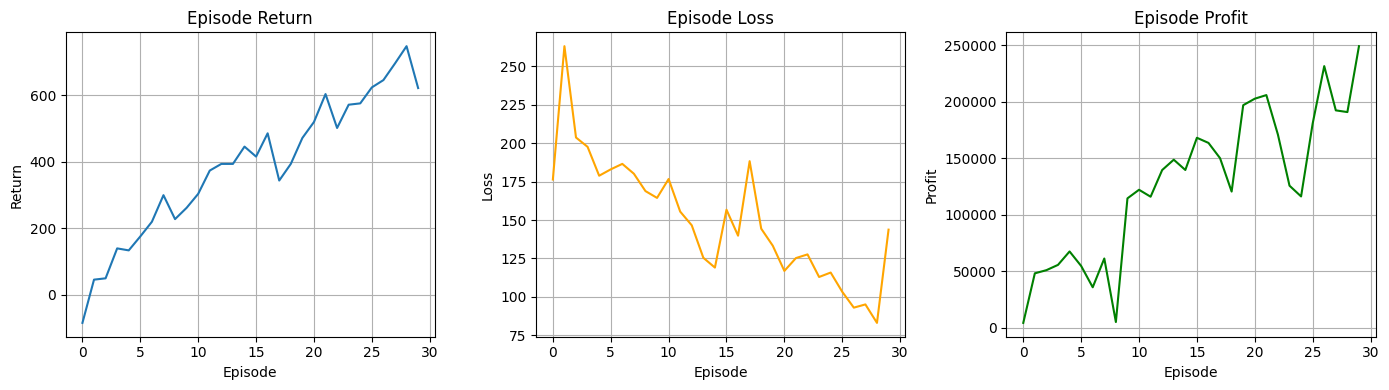

In [41]:
# Plot training metrics
trainer.plot_metrics()